# **Bank Marketing Campaign Analysis**

# **1. Introduction**

This project focuses on analyzing the "Bank Marketing" database from the UC Irvine Machine Learning Repository, which comprises data collected from phone marketing campaigns conducted by a Portuguese banking institution. The primary objective of these campaigns is to encourage customers to subscribe to term deposits offered by the bank.

The primary goals of the project are to discover actionable insights on the key factors influencing the success of the phone marketing campaign and to develop a predictive model that enables the sales team to prioritize potential customers effectively.

# **2. Data Preparation**

### Loading The Dataset

In [ ]:
import pandas as pd

df = pd.read_csv("bank-full.csv", sep=";")

### Variable Table for Bank Marketing Dataset

| Variable Name | Role    | Type      | Description                                                        | Units     | Missing Values |
|---------------|---------|-----------|--------------------------------------------------------------------|-----------|----------------|
| age           | Feature | Integer   | Age                                                                |           | no             |
| job           | Feature | Categorical | Type of job (e.g., 'admin.', 'blue-collar', 'management')        |           | no             |
| marital       | Feature | Categorical | Marital status (e.g., 'married', 'single', 'divorced')           |           | no             |
| education     | Feature | Categorical | Education level (e.g., 'basic.4y', 'high.school', 'university.degree') |       | no             |
| default       | Feature | Binary    | Has credit in default? (yes/no)                                   |           | no             |
| balance       | Feature | Integer   | Average yearly balance                                             | euros     | no             |
| housing       | Feature | Binary    | Has housing loan? (yes/no)                                       |           | no             |
| loan          | Feature | Binary    | Has personal loan? (yes/no)                                       |           | no             |
| contact       | Feature | Categorical | Contact communication type (e.g., 'cellular', 'telephone')       |           | yes            |
| day           | Feature | Date      | Last contact day of the month                                     |           | no             |
| month         | Feature | Categorical | Last contact month of the year (e.g., 'jan', 'feb', 'mar')      |           | no             |
| duration      | Feature | Integer   | Last contact duration in seconds                                   | seconds   | no             |
| campaign      | Feature | Integer   | Number of contacts performed during this campaign for this client  |           | no             |
| pdays         | Feature | Integer   | Days since the client was last contacted from a previous campaign |           | no             |
| previous      | Feature | Integer   | Number of contacts performed before this campaign for this client  |           | no             |
| poutcome      | Feature | Categorical | Outcome of the previous marketing campaign (e.g., 'success')     |           | no             |
| y             | Target  | Binary    | Has the client subscribed to a term deposit? (yes/no)             |           | no             |

In [ ]:
#Display all unique values of the categorical columns
cat = ['job','marital','education','contact','month','poutcome']
for col in cat:
  print(f"{col}: {df[col].unique()}\n")


job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

marital: ['married' 'single' 'divorced']

education: ['tertiary' 'secondary' 'unknown' 'primary']

contact: ['unknown' 'cellular' 'telephone']

month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

poutcome: ['unknown' 'failure' 'other' 'success']



In [ ]:
#Create new column to group similar jobs

occupation_map = {
    'management': 'white-collar',
    'technician': 'white-collar',
    'admin.': 'white-collar',
    'entrepreneur': 'white-collar',
    'self-employed': 'white-collar',
    'blue-collar': 'blue-collar',
    'services': 'blue-collar',
    'housemaid': 'blue-collar',
}

df['occupation_group'] = df['job'].replace(occupation_map)

Points to note:
1. As the data source ("https://archive.ics.uci.edu/dataset/222/bank+marketing") did not explain the "unknown" values, they are assumed to be missing values. Will check the proportion of 'unknown" value in the dataset and determine whether to remove them.
2. Column "poutcome" has values 'unknown' and 'other', which could indicate missing values or the customer did not participate in other marketing campaign before. Verification is required.

###Cleaning And Processing The Dataset

In [ ]:
#Check first 5 rows
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,occupation_group
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,white-collar
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,white-collar
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,white-collar
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,blue-collar
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,unknown


In [ ]:
#Check for missing values
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [ ]:
#Remove duplicate
df = df.drop_duplicates()

In [ ]:
#Check for "unknown"
cat.remove("contact")
for col in cat:
    count = (df[col]=='unknown').sum()
    print(f"No. of unknown in {col}: {count}")

No. of unknown in job: 288
No. of unknown in marital: 0
No. of unknown in education: 1857
No. of unknown in month: 0
No. of unknown in poutcome: 36959


As the number of unknown records in columns "job" and "education" is small, they will be removed to simplify the analysis process.

In [ ]:
#Verify what 'other' and 'unknown' represents in column 'poutcome'
print(f"'unknown' + no previous campaign: {df[(df.poutcome=='unknown') & (df.pdays==-1)].shape[0]}")
print(f"'other' + no previous campaign: {df[(df.poutcome=='other') & (df.pdays==-1)].shape[0]}")
print(f"'other': {df[df.poutcome=='other'].shape[0]}")

'unknown' + no previous campaign: 36954
'other' + no previous campaign: 0
'other': 1840


36,954 out of 36,959 of the customers with 'poutcome' == 'unknown' have not participated in other campaign before, which explains the unavailability of the data. Since the number of records is significant, and the data of new customer is important for the analysis, all of the records will be kept except the 5 outliers.

On the other hand, all customers with 'poutcome' == 'other' have previous campaign record but somehow the outcome is unavailable. Considering the number of records (1,840) is small, they will be removed to reduce noise in the dataset.

In [ ]:
#Remove unknown data from the dataset
df = df[
    (df.poutcome!='other') &
    (df.job!='unknown') &
    (df.education!='unknown') &
    ~((df.poutcome=='unknown') & (df.pdays!=-1))
]

df.shape

(41414, 18)

# **2. Exploratory Data Analysis (EDA)**

In [ ]:
#Get an overview of the dataset
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,41414.000000,41414.000000,41414.000000,41414.000000,41414.000000,41414.000000,41414.000000
mean,40.813469,1348.432390,15.866929,258.355387,2.770995,32.243831,0.436736
std,10.489728,3026.392369,8.307241,258.496537,3.103485,90.859877,1.569653
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,68.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,437.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1407.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,58.000000,871.000000,55.000000


For balance, duration, campaign, and pdays, max is significantly larger than median, suggesting there are outliers in these variables.

###Numerical Variables

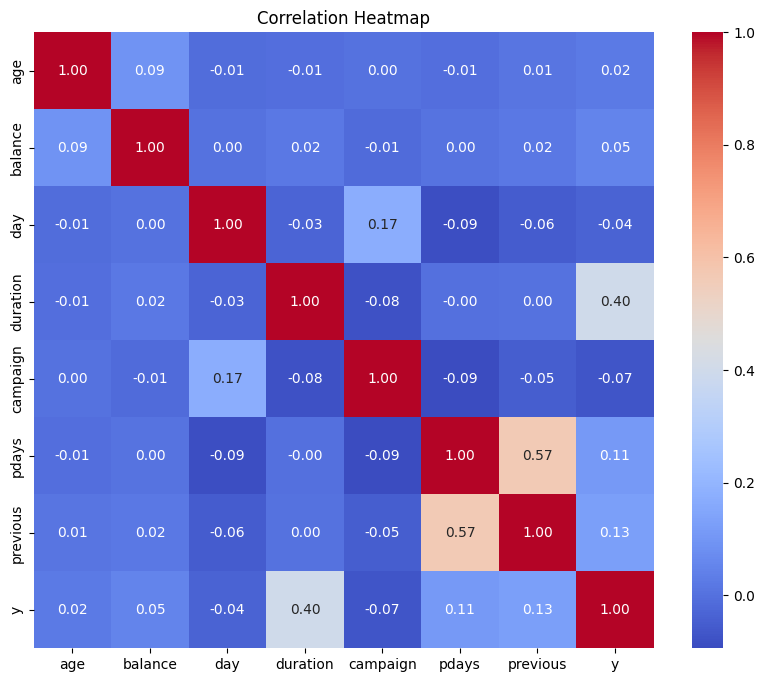

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Encode target variable 'y' (yes = 1, no = 0)
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


Initial findings:
1. "Duration" has the highest correlation coefficient (0.4) with target "y", which suggests that there is a moderate positive relationship between the 2.

2. The correlation coefficient between "y" and other variables are lower than 0.2, suggesting there is no or very weak linear relationship between them.  Further investigation to check if a non-linear relationship exists instead.

3. The correlation coefficient between "pdays" and "previous" is 0.57, which suggests a strong positive relationship. To avoid colinearity, "pdays" will not be used in the subsequent analysis as it has lower correlation with target "y".


<Axes: ylabel='duration'>

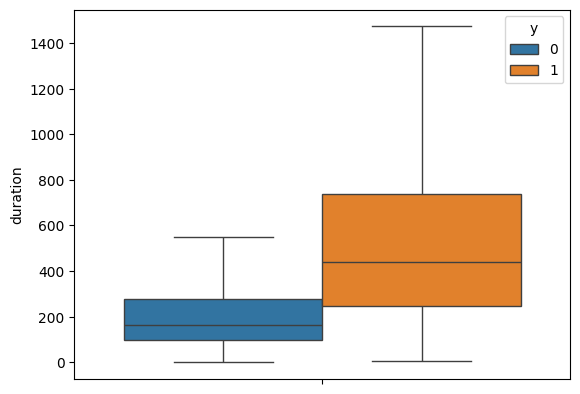

In [ ]:
#Box plot for "duration"
sns.boxplot(data=df, y="duration", hue="y", showfliers=False)

From the plot, the box for y=1 is higher in median, max value, 1st quartile, and 3rd quartile. It can be deduced that longer duration is more likely to result in a subscription.

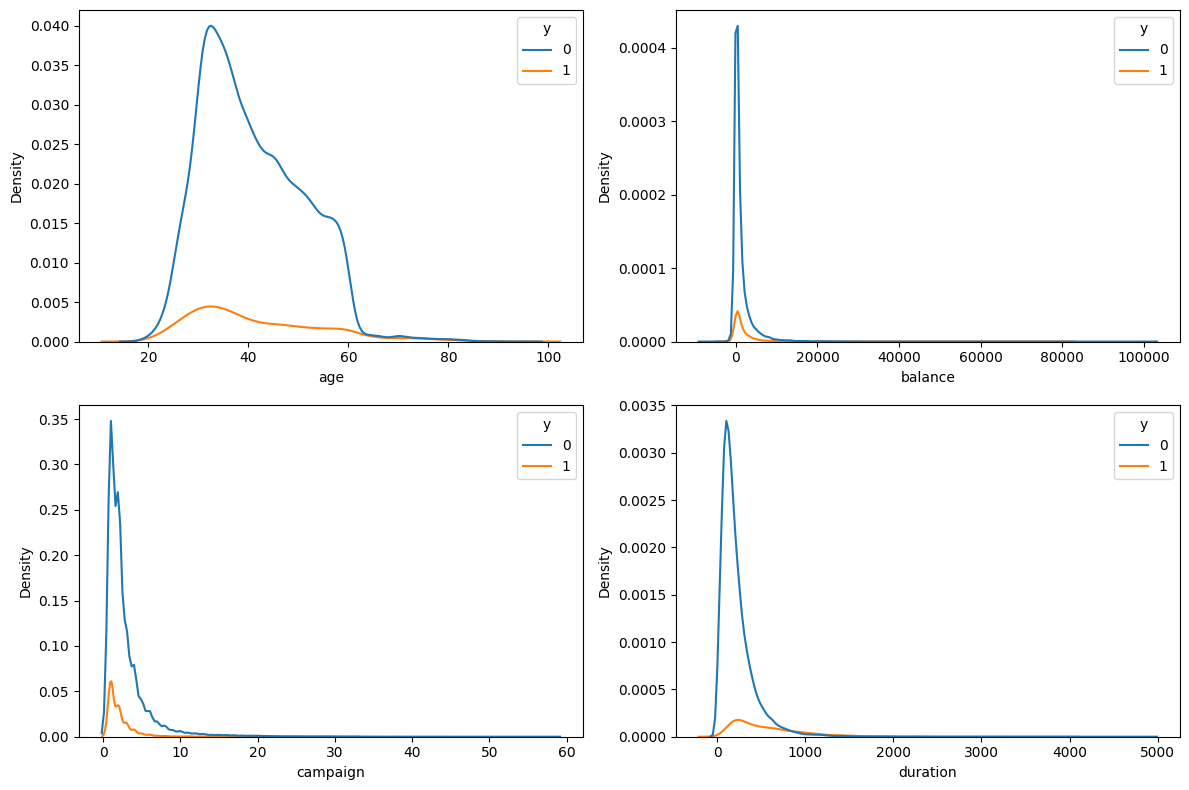

In [ ]:
#Desity plot for all numeric variables
fig, axes = plt.subplots(2,2,figsize=(12,8))

sns.kdeplot(data=df, x="age", hue="y", ax=axes[0,0])
sns.kdeplot(data=df, x="balance", hue="y", ax=axes[0,1])
sns.kdeplot(data=df, x="campaign", hue="y", ax=axes[1,0])
sns.kdeplot(data=df, x="duration", hue="y", ax=axes[1,1])

fig.tight_layout()
plt.show()

The plots for balance, campaign, and duration are extremely right-skewed due to the outliers. To uncover the underlying pattern, log transformation will be performed.

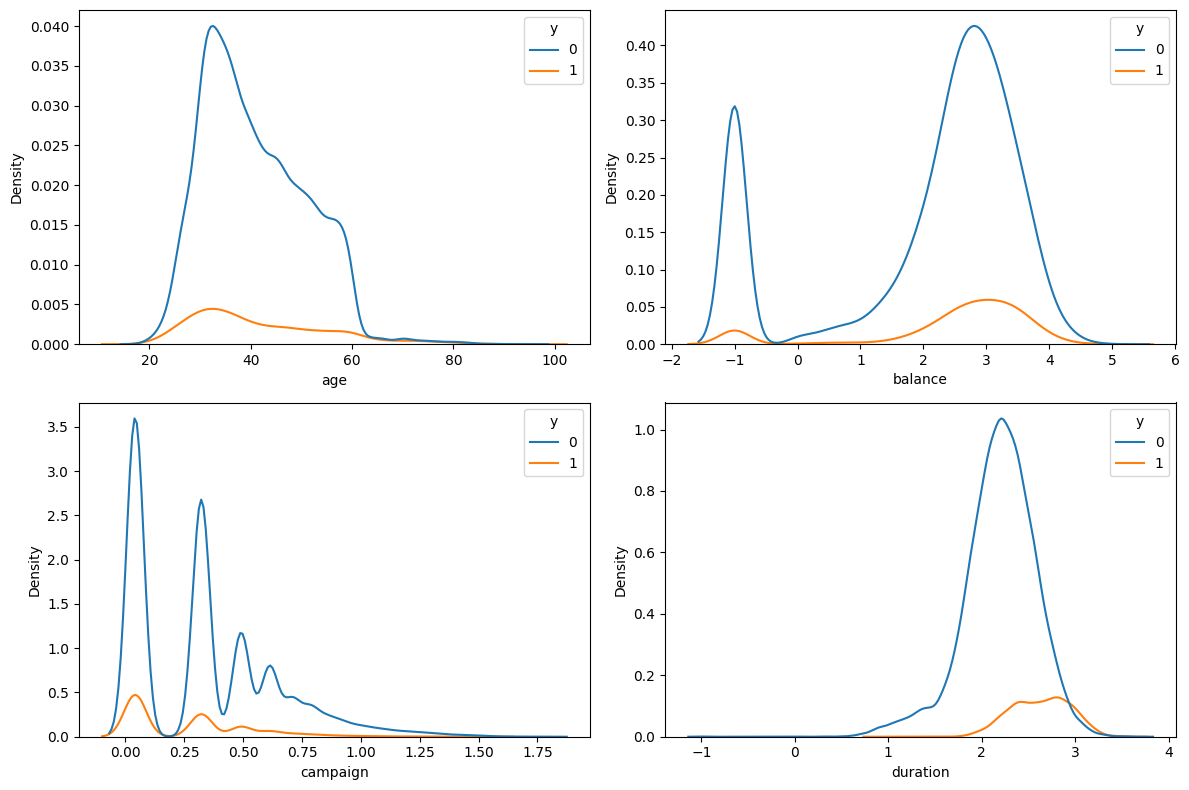

In [ ]:
#Perform log transformation on balance, campaign, and duration to deal with the right-skewed data
import numpy as np

#Turn negative values in balance to 0
balance_adj = df["balance"].clip(lower=0)

#Add 0.1 to avoid log(0)
log_balance = np.log10(balance_adj + 0.1)
log_campaign = np.log10(df["campaign"] + 0.1)
log_duration = np.log10(df["duration"] + 0.1)

#Density plots
fig, axes = plt.subplots(2,2,figsize=(12,8))

sns.kdeplot(data=df, x="age", hue="y", ax=axes[0,0])
sns.kdeplot(x=log_balance, hue=df["y"], ax=axes[0,1])
sns.kdeplot(x=log_campaign, hue=df["y"], ax=axes[1,0])
sns.kdeplot(x=log_duration, hue=df["y"], ax=axes[1,1])

fig.tight_layout()
plt.show()



**1. Age**  
  Customers are concentrated in age 20 to 60. Biggest gap between the curve y=1 and y=0 is observed at age=30, but then closes as age increases and the curves eventually overlapped at around age=62. It can be deduced that customers with age above 30 are more inclined to subscribe, and the likelihood increases with age.
  
**2. Balance**  
  The 2 curves follow a very similar pattern and both peaked at log_balance=-1 and 3. However, smaller gap is observed at log_balance=3, suggesting that customers with higher account balance are more likely to subscribe.

**3. Campaign**  
  For y=0, the density decreases as log_balance increases, showing marginal effect of campaign contacts on subscription.

**4. Duration**  
  y = 0 peaks at log_balance=2.5 then declines sharply, while y=1 peaks at log_duration=2.5 to 3. It indicates that longer duration promotes higher chance of subscription.

###Categorical Variables

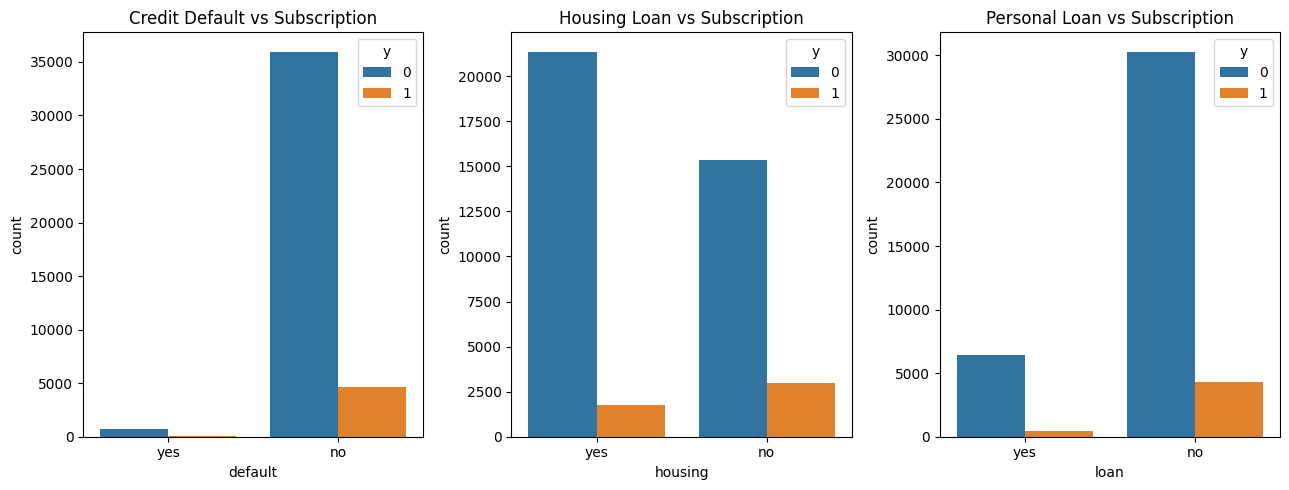

In [ ]:
#Count plot for binary variables
fig, axes = plt.subplots(1,3,figsize=(13,5))

sns.countplot(data=df, x='default', hue='y', ax=axes[0], order=["yes","no"])
axes[0].set_title("Credit Default vs Subscription")

sns.countplot(data=df, x='housing', hue='y', ax=axes[1])
axes[1].set_title("Housing Loan vs Subscription")

sns.countplot(data=df, x='loan', hue='y', ax=axes[2], order=["yes","no"])
axes[2].set_title("Personal Loan vs Subscription")

fig.tight_layout()
plt.show()

**1. Credit Default vs Subscription**  
  The distribution is significantly imbalance, which may skew the result of the analysis and the prediction model.  
  
**2. Housing Loan vs Subscription**  
  The distribution of the variable is reasonably balance. The subscription rate of customers with no housing loan is obervably higher than customers with housing loan, suggesting that customers without a housing loan are more likely to subscibe.

**3. Personal Loan vs Subscription**  
  Similar to credit default, the distribution of personal loan is also
  imbalance.

---
All three variables reflect how the finanical situation of the customer affect their willingness to subscribe. However, to simplify the analysis process, the analysis will only focus on "housing" among the 3 as its distribution is the most balance and it shows a relatively strong relationship with target y.



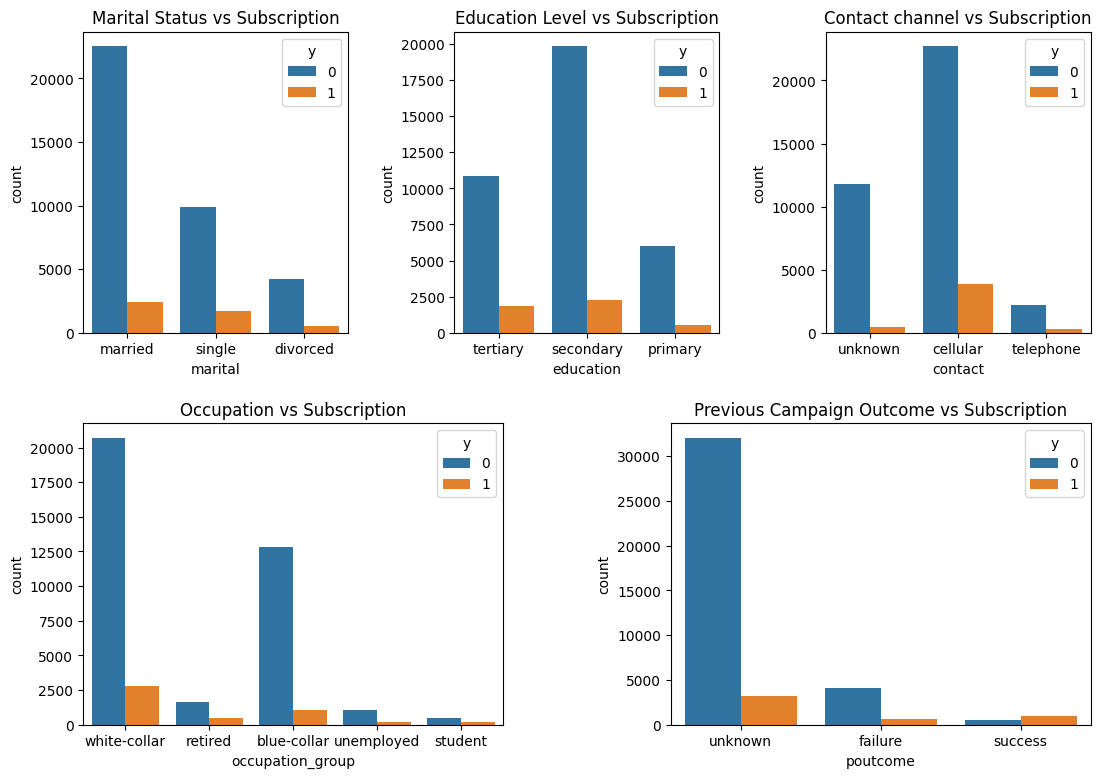

In [ ]:
#Count plot for categorical variables
fig = plt.figure(figsize=(13, 9))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

ax1 = fig.add_subplot(2,3,1)
sns.countplot(data=df, x='marital', hue='y', ax=ax1)
ax1.set_title("Marital Status vs Subscription")

ax2 = fig.add_subplot(2,3,2)
sns.countplot(data=df, x='education', hue='y', ax=ax2)
ax2.set_title("Education Level vs Subscription")

ax3 = fig.add_subplot(2,3,3)
sns.countplot(data=df, x='contact', hue='y', ax=ax3)
ax3.set_title("Contact channel vs Subscription")

ax4 = fig.add_subplot(2,2,3)
sns.countplot(data=df, x='occupation_group', hue='y', ax=ax4)
ax4.set_title("Occupation vs Subscription")

ax5 = fig.add_subplot(2,2,4)
sns.countplot(data=df, x='poutcome', hue='y', ax=ax5)
ax5.set_title("Previous Campaign Outcome vs Subscription")


plt.show()

**1. Marital Status vs Subscription**  
  The trends of the 3 marital statuses are observed to follow a very similar trend. This variable seems to have low correlation with subscription rate and have low prediction power.

**2. Education Level vs Subscription**  
  The plot shows meaningful differentiation in subsription rate across different education level, where higher education level has higher subscription rate, suggesting a positive relationship exists.

**3. Contact channel vs Subscription**  
  The distribution of the variable is significantly skewed, where a huge majority of samples are "unknown" and "cellular". While "cellular" contact does show higher subscription rate, cellular contact is the default contact channel anyway in the context of phone marketing campaign, making the insight much less meaningful.

**4. Occupation vs Subscription**  
  All occupations other than student shows a similar subscription rate. Although student has a higher subscription rate, the sample size is too small to make a reliable conclusion.

**5. Previous Campaign Outcome vs Subscription**  
  Despite of its significant skeweness, "success" does show a much higher subscription rate. Also, on a business standpoint, it makes sense that customers who subscribed before are more likely to subscribe again compared to new customer.

---
Based on the above evaluation, "contact" will be dropped as it is skewed and provide inconsequancial insight to the analysis.


#**3. Prediction Model Using scikit-learn**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

##Preparing the data for modelling

In [ ]:
#Encode categorical variables using one-hot encoding
df_encoded = df.drop(["default","pdays", "campaign", "loan", "contact"], axis=1)
df_encoded = pd.get_dummies(df_encoded,drop_first=True)

#Convert all boolean to int
pd.set_option('future.no_silent_downcasting', True)
df_encoded = df_encoded.replace({True: 1, False:0})

#Logistic Regression

In [ ]:
x = df_encoded.drop("y", axis=1)
y = df["y"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter = 10000, random_state=42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7335
           1       0.66      0.36      0.47       948

    accuracy                           0.91      8283
   macro avg       0.79      0.67      0.71      8283
weighted avg       0.89      0.91      0.89      8283

[[7158  177]
 [ 604  344]]


The logistic regression model performs well with predicting negatives but struggles with the positives, with fair precision of 0.66 and poor recall of 0.36. This reflects the model has issues with false negatives and this is potentially caused by the imbalance sample. New modelling method will be experimented to improve performance.

#Random Forest Classifier

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

model2 = BalancedRandomForestClassifier(random_state=42)
model2.fit(x_train, y_train)
y_pred2 = model2.predict(x_test)

print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7335
           1       0.45      0.84      0.59       948

    accuracy                           0.87      8283
   macro avg       0.71      0.85      0.75      8283
weighted avg       0.92      0.87      0.88      8283

[[6377  958]
 [ 156  792]]


The recall of the positive class significantly improved from 0.36 to 0.84. However, precision also dropped from 0.66 to 0.45. It means that the random forest classifier is superior in predicting positive, but is worse in predicting negative.

In the context of phone marketing, where identifying potential customers is much more important than filtering out customers that are not interested, random forest classifier is much more effective.

#**4. Conclusion**

##Key Findings

**1. Positive relationship between subscription and phone call duration**
- The correlation coefficient between subscription and phone call duration is 0.4, indicating a moderate positive relationship. This suggests customers who stay on the phone longer are more likely to subscribe.
- Subscription rate peaks around 15 mintues mark.

**2. Demographic**
- Customers aged above 30 are more likely to subscirbe. The likelihood increases with age.
- Financial situation of customer seems to also affect subsciption rate. Loan-free customers and customers with higher account balance are more willing to subscribe.

**3. Influence of repeated calls**
- Surprisingly, number of contacts made during the campaign appears to have weak relationship with subscription.
- In fact, subscription rate drops as number of contacts increases.

**4. Re-subscription**
- Customers who subscribed before show a significantly higher chance to subscribe again.
- However, the sample size is too small to make a definitive conclusion.

**5. Low success rate**
- Out of 8283 customers in the database, only 948 of them agreed to subscribe.
- Subscription rate is 11.45%.

##Actionable insights

**1. Optimize call strategy**
- Sales representatives may focus more on building rapport during the call to keep customers' interest.
- Optimize the script for a 15 minutes conversation, where subscription rate observed to be the highest.
- Limit repeated calls during campaigns. Strive for quality over quantity.

**2. Refine customer targeting**
- Prioritize customers that are above 30, loan-free, or have a relatively higher account balance.
- Design campaigns that emphasize financial benefits and affordability to attract less financially stable customers.
- Loyalty program could also be effective to encourage resubscription.

**3. Leverage the prediction model**
- Identify potential customers using the prediction model.
- Provide personalized offer to them to maximize success rate, if time and resources allow.

**4. Reevaluate the cost-effectiveness of phone marketing campaign**
- In light of the low subscription rate (11.45%) in the campaign, sales and marketing team may need to explore other sales channels.
- Data on the cost of the campaign can also be collected in the future to evaluate the return on investment of the campaign.
